# Nearest Correlation Matrix with NAG

Import required modules and set print options

In [42]:
import numpy as np
import nag4py.g02 as nag_g02
import nag4py.util as nag_util
import matplotlib.pyplot as plt
"Plot inline"
%matplotlib inline
"Set the print precision."
np.set_printoptions(precision=4)

## Start with an incomplete matrix P

In [43]:
"Define a 2-d array and us np.nan to set the NaNs."
P = np.array([[59.875, 42.734, 47.938, 60.359, 54.016, 69.625, 61.500, 62.125],
              [53.188, 49.000, 39.500, np.nan, 34.750, np.nan, 83.000, 44.500],
              [55.750, 50.000, 38.938, np.nan, 30.188, np.nan, 70.875, 29.938],
              [65.500, 51.063, 45.563, 69.313, 48.250, 62.375, 85.250, np.nan],
              [69.938, 47.000, 52.313, 71.016, np.nan, 59.359, 61.188, 48.219],
              [61.500, 44.188, 53.438, 57.000, 35.313, 55.813, 51.500, 62.188],
              [59.230, 48.210, 62.190, 61.390, 54.310, 70.170, 61.750, 91.080],
              [61.230, 48.700, 60.300, 68.580, 61.250, 70.340, np.nan, np.nan],
              [52.900, 52.690, 54.230, np.nan, 68.170, 70.600, 57.870, 88.640],
              [57.370, 59.040, 59.870, 62.090, 61.620, 66.470, 65.370, 85.840]])

In [44]:
def cov_bar(P):
    """Returns an approximate sample covarience matrix"""
    "P.shape returns a tuple (m, n) that we unpack to m and n."
    m, n = P.shape
    "Initialise an nxn zero matrix."
    S = np.zeros((n, n))
    "i = 0, ..., 7."
    for i in range(0, n): 
        "Take the ith column."
        xi = P[:, i]
        "j = 0, ..., i"
        for j in range(0, i+1):
            "Take the jth column, where j <= i."
            xj = P[:, j] 
            """masked_array masks elements marked as True; this is the opposite behaviour of 
the MATLAB script. Therefore, we need ~(~np.isnan(xi) & ~np.isnan(xj)), which I 
have simplified below and will label notp."""
            "Set mask such that all nans are True."
            notp = np.isnan(xi) | np.isnan(xj) 
            "Apply the mask to xi"
            xim = np.ma.masked_array(xi, mask=notp)
            "Apply the mask to xj"
            xjm = np.ma.masked_array(xj, mask=notp) 
            S[i, j] = np.ma.dot(xim - np.mean(xim), xjm - np.mean(xjm))
            """As we used notp as our mask, we must take the sum over ~notp to give the 
same result as the MATLAB script when normalising."""
            S[i, j] = 1.0 / (sum(~notp) - 1) * S[i, j]
            S[j, i] = S[i, j]
    return S

In [45]:
def cor_bar(P):
    """Returns an approximate sample correlation matrix"""
    S = cov_bar(P)
    D = np.diag(1.0 / np.sqrt(np.diag(S)))
    "This is will only work in Python3"
    return D @ S @ D 


## Calculate the correlation matrix of P.

In [46]:
G = cor_bar(P)
print(G)

[[ 1.     -0.325   0.1881  0.576   0.0064 -0.6111 -0.0724 -0.1589]
 [-0.325   1.      0.2048  0.2436  0.4058  0.273   0.2869  0.4241]
 [ 0.1881  0.2048  1.     -0.1325  0.7658  0.2765 -0.6172  0.9006]
 [ 0.576   0.2436 -0.1325  1.      0.3041  0.0126  0.6452 -0.321 ]
 [ 0.0064  0.4058  0.7658  0.3041  1.      0.6652 -0.3293  0.9939]
 [-0.6111  0.273   0.2765  0.0126  0.6652  1.      0.0492  0.5964]
 [-0.0724  0.2869 -0.6172  0.6452 -0.3293  0.0492  1.     -0.3983]
 [-0.1589  0.4241  0.9006 -0.321   0.9939  0.5964 -0.3983  1.    ]]


### Some of the eigenvalues are negative and therefore the matrix is not semi-positive definite.

In [47]:
print("The sorted eigenvalues of G {}".format(np.sort(np.linalg.eig(G)[0])))

The sorted eigenvalues of G [-0.2498 -0.016   0.0895  0.2192  0.7072  1.7534  1.9611  3.5355]


## Use g02aa to calculate the nearest correlation matrix in the Frobenius norm

In [48]:
order = nag_util.Nag_RowMajor
Gflat = G.flatten()
n = G.shape[0]
pdg = n
errtol = 0.0
maxits = 0
maxit = 0
Xflat = np.empty_like(Gflat)
pdx = n
itr = np.array([0])
feval = np.array([0])
nrmgrd = np.array([0.0])
fail = nag_util.noisy_fail()
nag_g02.g02aac(order, Gflat, pdg, n, errtol, maxits, 
               maxit, Xflat, pdx, itr, feval, nrmgrd, fail)

In [49]:
"Unflatten X to have the same shape as G for comparison."
X = np.reshape(Xflat, G.shape) 
print(X)

[[ 1.     -0.3112  0.1889  0.5396  0.0268 -0.5925 -0.0621 -0.1921]
 [-0.3112  1.      0.205   0.2265  0.4148  0.2822  0.2915  0.4088]
 [ 0.1889  0.205   1.     -0.1468  0.788   0.2727 -0.6085  0.8802]
 [ 0.5396  0.2265 -0.1468  1.      0.2137  0.0015  0.6069 -0.2208]
 [ 0.0268  0.4148  0.788   0.2137  1.      0.658  -0.2812  0.8762]
 [-0.5925  0.2822  0.2727  0.0015  0.658   1.      0.0479  0.5932]
 [-0.0621  0.2915 -0.6085  0.6069 -0.2812  0.0479  1.     -0.447 ]
 [-0.1921  0.4088  0.8802 -0.2208  0.8762  0.5932 -0.447   1.    ]]


In [50]:
print("The sorted eigenvalues of X [{0}]".format(''.join(
            ['{:.4f} '.format(x) for x in np.sort(np.linalg.eig(X)[0])])))

The sorted eigenvalues of X [-0.0000 -0.0000 0.0380 0.1731 0.6894 1.7117 1.9217 3.4661 ]


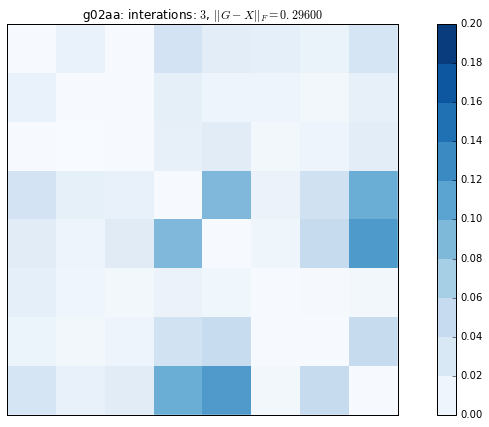

In [51]:
fig1, ax1 = plt.subplots(figsize=(14, 7))
cax1 = ax1.imshow(abs(X-G), interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=0.2)
cbar = fig1.colorbar(cax1, ticks = np.linspace(0.0, 0.2, 11, endpoint=True), 
                     boundaries=np.linspace(0.0, 0.2, 11, endpoint=True))
cbar.set_clim([0, 0.2])
ax1.tick_params(axis='both', which='both', 
                bottom='off', top='off', left='off', right='off', 
                labelbottom='off', labelleft='off')
ax1.set_title(r'g02aa: interations: ${0}$, $||G-X||_F = {1:.5f}$'.format(itr[0], 
                                                                       np.linalg.norm(X-G)))
plt.show()

## Use g02ab to calculate the nearest correlation matrix with row and column weighting

### Define the weights as follows

In [52]:
W = np.array([10, 10, 10, 1, 1, 1, 1, 1], dtype = np.float64)

In [53]:
order = nag_util.Nag_RowMajor
Gflat = G.flatten()
n = G.shape[0]
opt = nag_util.Nag_Both
alpha = 0.001
pdg = n
errtol = 0.0
maxits = 0
maxit = 0
Xflat = np.empty_like(Gflat)
pdx = n
itr = np.array([0])
feval = np.array([0])
nrmgrd = np.array([0.0])
fail = nag_util.noisy_fail()
nag_g02.g02abc(order, Gflat, pdg, n, opt, alpha, W, errtol, maxits, 
               maxit, Xflat, pdx, itr, feval, nrmgrd, fail)

In [54]:
X = np.reshape(Xflat, G.shape)
print(X)

[[ 1.     -0.3247  0.1879  0.5733  0.0067 -0.609  -0.0721 -0.1596]
 [-0.3247  1.      0.2046  0.2423  0.4056  0.2735  0.2867  0.4232]
 [ 0.1879  0.2046  1.     -0.1321  0.7654  0.2756 -0.6164  0.8995]
 [ 0.5733  0.2423 -0.1321  1.      0.2083 -0.0889  0.5948 -0.1804]
 [ 0.0067  0.4056  0.7654  0.2083  1.      0.655  -0.2777  0.8748]
 [-0.609   0.2735  0.2756 -0.0889  0.655   1.      0.049   0.574 ]
 [-0.0721  0.2867 -0.6164  0.5948 -0.2777  0.049   1.     -0.4545]
 [-0.1596  0.4232  0.8995 -0.1804  0.8748  0.574  -0.4545  1.    ]]


In [55]:
print("The sorted eigenvalues of X [{0}]".format(''.join(
            ['{:.4f} '.format(x) for x in np.sort(np.linalg.eig(X)[0])])))

The sorted eigenvalues of X [0.0020 0.0020 0.0315 0.1655 0.6767 1.7708 1.8901 3.4614 ]


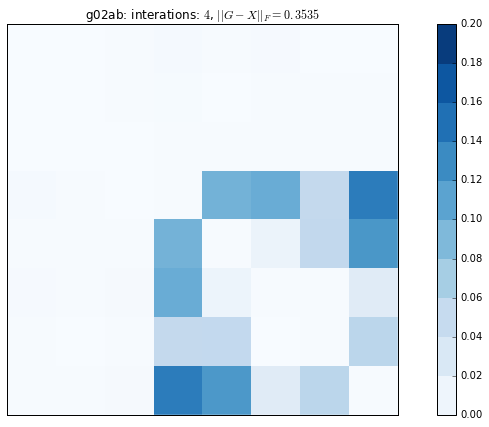

In [56]:
fig1, ax1 = plt.subplots(figsize=(14, 7))
cax1 = ax1.imshow(abs(X-G), interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=0.2)
cbar = fig1.colorbar(cax1, ticks = np.linspace(0.0, 0.2, 11, endpoint=True), 
                     boundaries=np.linspace(0.0, 0.2, 11, endpoint=True))
cbar.set_clim([0, 0.2])
ax1.tick_params(axis='both', which='both', 
                bottom='off', top='off', left='off', right='off', 
                labelbottom='off', labelleft='off')
ax1.set_title(r'g02ab: interations: ${0}$, $||G-X||_F = {1:.4f}$'.format(itr[0], 
                                                                       np.linalg.norm(X-G)))
plt.show()

## Use g02aj to calculate the nearest correlation matrix with element-wise weighting

In [57]:
H = np.ones([n, n])
H[0:3, 0:3] = 100

In [58]:
Gflat = G.flatten()
n = G.shape[0]
alpha = 0.001
Hflat = H.flatten()
pdg = n
pdh = n
errtol = 0.0
maxits = 0
maxit = 500
Xflat = np.empty_like(Gflat)
pdx = n
itr = np.array([0])
norm = np.array([0.0])
fail = nag_util.noisy_fail()
nag_g02.g02ajc(Gflat, pdg, n, alpha, Hflat, pdh, errtol, 
               maxit, Xflat, pdx, itr, norm, fail)

In [59]:
X = np.reshape(Xflat, G.shape)
print(X)

[[ 1.     -0.3247  0.188   0.5091  0.0306 -0.5611 -0.0569 -0.1701]
 [-0.3247  1.      0.2047  0.2146  0.3837  0.2504  0.2676  0.3781]
 [ 0.188   0.2047  1.     -0.1331  0.7175  0.2534 -0.5607  0.812 ]
 [ 0.5091  0.2146 -0.1331  1.      0.2081  0.0145  0.6079 -0.2272]
 [ 0.0306  0.3837  0.7175  0.2081  1.      0.6622 -0.282   0.8732]
 [-0.5611  0.2504  0.2534  0.0145  0.6622  1.      0.0482  0.5982]
 [-0.0569  0.2676 -0.5607  0.6079 -0.282   0.0482  1.     -0.4438]
 [-0.1701  0.3781  0.812  -0.2272  0.8732  0.5982 -0.4438  1.    ]]


In [60]:
print("The sorted eigenvalues of X [{0}]".format(''.join(
            ['{:.4f} '.format(x) for x in np.sort(np.linalg.eig(X)[0])])))

The sorted eigenvalues of X [0.0020 0.0129 0.1162 0.2104 0.7367 1.6700 1.8892 3.3627 ]


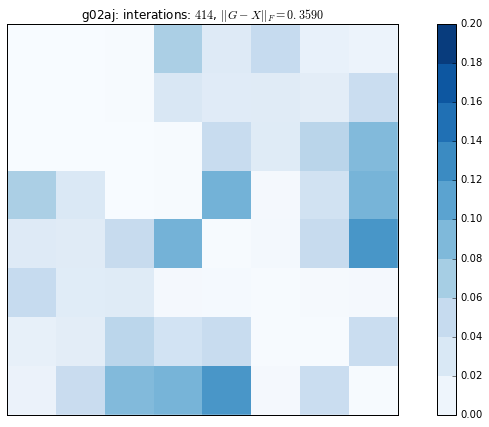

In [61]:
fig1, ax1 = plt.subplots(figsize=(14, 7))
cax1 = ax1.imshow(abs(X-G), interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=0.2)
cbar = fig1.colorbar(cax1, ticks = np.linspace(0.0, 0.2, 11, endpoint=True), 
                     boundaries=np.linspace(0.0, 0.2, 11, endpoint=True))
cbar.set_clim([0, 0.2])
ax1.tick_params(axis='both', which='both', 
                bottom='off', top='off', left='off', right='off', 
                labelbottom='off', labelleft='off')
ax1.set_title(r'g02aj: interations: ${0}$, $||G-X||_F = {1:.4f}$'.format(itr[0], 
                                                                       np.linalg.norm(X-G)))
plt.show()

## Use g02an to calculate the nearest correlation matrix with fixed leading block

In [62]:
Gflat = G.flatten()
n = G.shape[0]
pdg = n
k = 3
errtol = 0.0
eigtol = 0.0
maxits = 0
maxit = 500
Xflat = np.empty_like(Gflat)
pdx = n
alpha = np.array([0.0])
itr = np.array([0], dtype=nag_util.nag_int_type)
eigmin = np.array([0.0])
norm = np.array([0.0])
fail = nag_util.noisy_fail()
nag_g02.g02anc(Gflat, pdg, n, k, errtol, eigtol, Xflat, pdx, 
               alpha, itr, eigmin, norm, fail)

In [63]:
#X = np.reshape(Xflat, G.shape)
print(X)

[[ 1.     -0.3247  0.188   0.5091  0.0306 -0.5611 -0.0569 -0.1701]
 [-0.3247  1.      0.2047  0.2146  0.3837  0.2504  0.2676  0.3781]
 [ 0.188   0.2047  1.     -0.1331  0.7175  0.2534 -0.5607  0.812 ]
 [ 0.5091  0.2146 -0.1331  1.      0.2081  0.0145  0.6079 -0.2272]
 [ 0.0306  0.3837  0.7175  0.2081  1.      0.6622 -0.282   0.8732]
 [-0.5611  0.2504  0.2534  0.0145  0.6622  1.      0.0482  0.5982]
 [-0.0569  0.2676 -0.5607  0.6079 -0.282   0.0482  1.     -0.4438]
 [-0.1701  0.3781  0.812  -0.2272  0.8732  0.5982 -0.4438  1.    ]]


In [64]:
print("The sorted eigenvalues of X [{0}]".format(''.join(
            ['{:.4f} '.format(x) for x in np.sort(np.linalg.eig(X)[0])])))

The sorted eigenvalues of X [0.0020 0.0129 0.1162 0.2104 0.7367 1.6700 1.8892 3.3627 ]


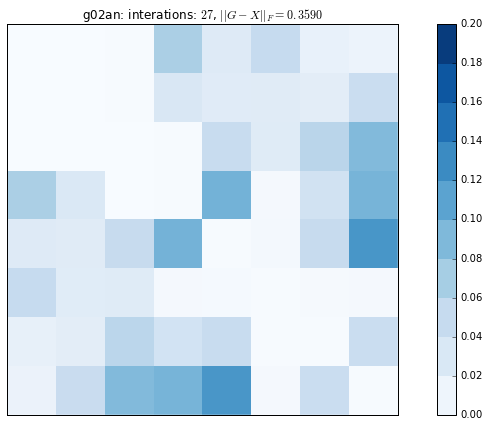

In [65]:
fig1, ax1 = plt.subplots(figsize=(14, 7))
cax1 = ax1.imshow(abs(X-G), interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=0.2)
cbar = fig1.colorbar(cax1, ticks = np.linspace(0.0, 0.2, 11, endpoint=True),
                     boundaries=np.linspace(0.0, 0.2, 11, endpoint=True))
cbar.set_clim([0, 0.2])
ax1.tick_params(axis='both', which='both', 
                bottom='off', top='off', left='off', right='off', 
                labelbottom='off', labelleft='off')
ax1.set_title(r'g02an: interations: ${0}$, $||G-X||_F = {1:.4f}$'.format(itr[0], 
                                                                       np.linalg.norm(X-G)))
plt.show()